In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, AveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
dataset_path = "/content/drive/MyDrive/ProgressSoft /Face Mask Detection /Face Mask Dataset" #DataSetLink:https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.0001

In [ ]:
#Data Augumentaion performed on training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1.0/255) #Normlisation On Validation data
test_datagen = ImageDataGenerator(rescale=1.0/255) #Normlisation On Test data


In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False
)


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


Class 0 for wearing a Mask and Class 1 for not wearing A mask

In [ ]:
# Function to visualize some training images
def visualize_images(generator, title):
    images, labels = next(generator)
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Label: {int(labels[i])}")
        ax.axis("off")
    plt.show()

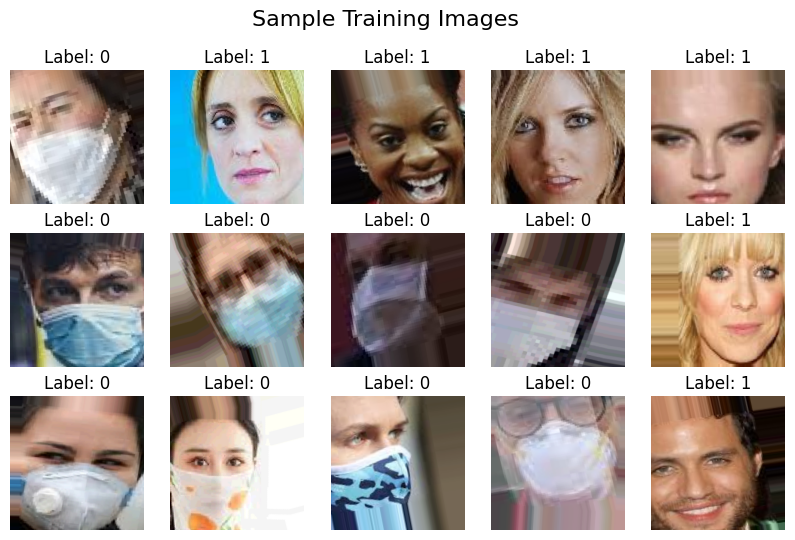

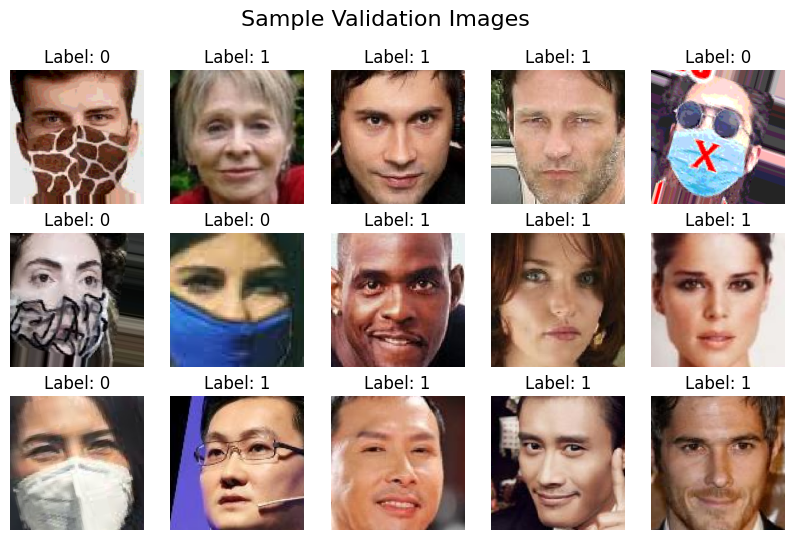

In [ ]:
# Visualize Training and Validation Images
visualize_images(train_generator, "Sample Training Images")
visualize_images(val_generator, "Sample Validation Images")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

<ipython-input-8-082d1beab1e3>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [ ]:
# Define custom classifier on top of MobileNetV2
x = base_model.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten(name="flatten")(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)  # Binary classification (Mask or No Mask)

In [ ]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=LEARNING_RATE), metrics=["accuracy"])

# Saving Checkpoints

In [ ]:
full_path = os.path.join(dataset_path, "training_1")

In [ ]:
os.makedirs(full_path, exist_ok=True)

In [ ]:
checkpoint_path = os.path.join(full_path, "cp.weights.h5") # Since you're only saving weights, you should use the .weights.h5 extension. If you're saving the whole model, you would use the .keras extension instead
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Training

In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=10,
    callbacks=[early_stop,cp_callback]

)

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9659
Epoch 1: saving model to /content/drive/MyDrive/ProgressSoft /Face Mask Detection /Face Mask Dataset/training_1/cp.weights.h5
313/313 [==============================] - 1911s 6s/step - loss: 0.0985 - accuracy: 0.9659 - val_loss: 0.0461 - val_accuracy: 0.9812
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9756
Epoch 2: saving model to /content/drive/MyDrive/ProgressSoft /Face Mask Detection /Face Mask Dataset/training_1/cp.weights.h5
313/313 [==============================] - 591s 2s/step - loss: 0.0718 - accuracy: 0.9756 - val_loss: 0.0402 - val_accuracy: 0.9850
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9791
Epoch 3: saving model to /content/drive/MyDrive/ProgressSoft /Face Mask Detection /Face Mask Dataset/training_1/cp.weights.h5
313/313 [==============================] - 590s 2s/step - loss: 0.060

In [ ]:
os.listdir(checkpoint_dir)

['cp.weights.h5']

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [ ]:
test_generator.reset()
predictions = (model.predict(test_generator) > 0.5).astype("int32")
true_labels = test_generator.classes

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 309s 10s/step


In [ ]:
print(predictions.shape, true_labels.shape)


(992, 1) (992,)


In [ ]:
print(set(true_labels))

{np.int32(0), np.int32(1)}


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9962 - loss: 0.0192
Test Accuracy: 99.29%


In [ ]:
model_path = os.path.join(dataset_path, "saved_model")
os.makedirs(model_path, exist_ok=True)

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
tf.saved_model.save(model, 'saved_model')

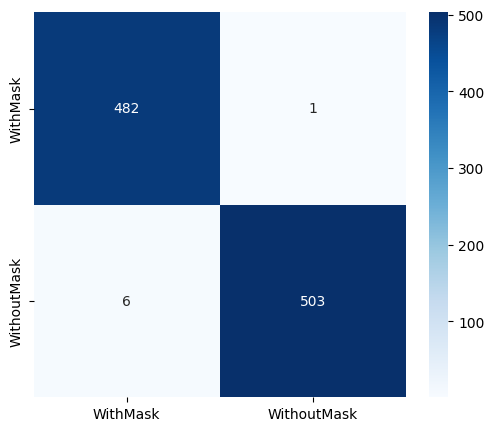

In [ ]:
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["WithMask", "WithoutMask"], yticklabels=["WithMask", "WithoutMask"])
plt.show()

Classification Report:
               precision    recall  f1-score   support

        Mask       0.99      1.00      0.99       483
     No Mask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


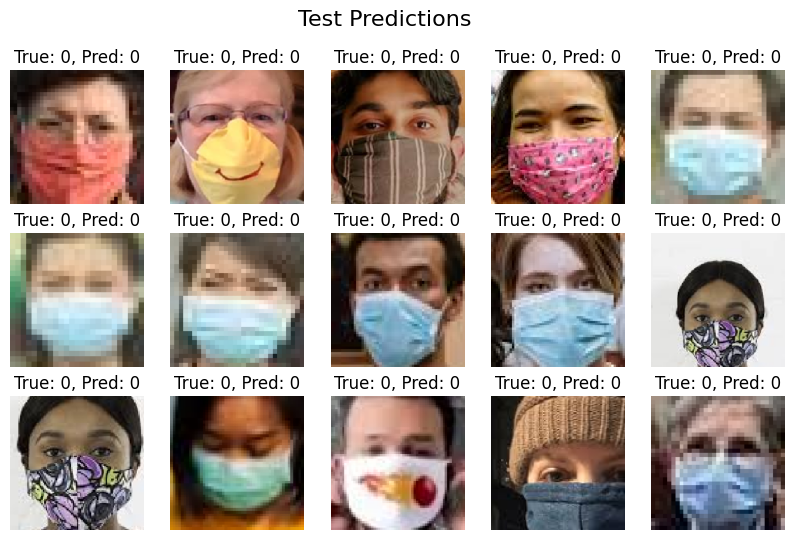

In [ ]:
# Print classification report
print("Classification Report:\n", classification_report(true_labels, predictions, target_names=["Mask", "No Mask"]))

# Function to visualize model predictions
def visualize_predictions(generator, model, title):
    images, labels = next(generator)
    predictions = model.predict(images)
    predictions = np.round(predictions).astype(int).flatten()

    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"True: {int(labels[i])}, Pred: {predictions[i]}")
        ax.axis("off")

    plt.show()

# Visualize predictions on test images
visualize_predictions(test_generator, model, "Test Predictions")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


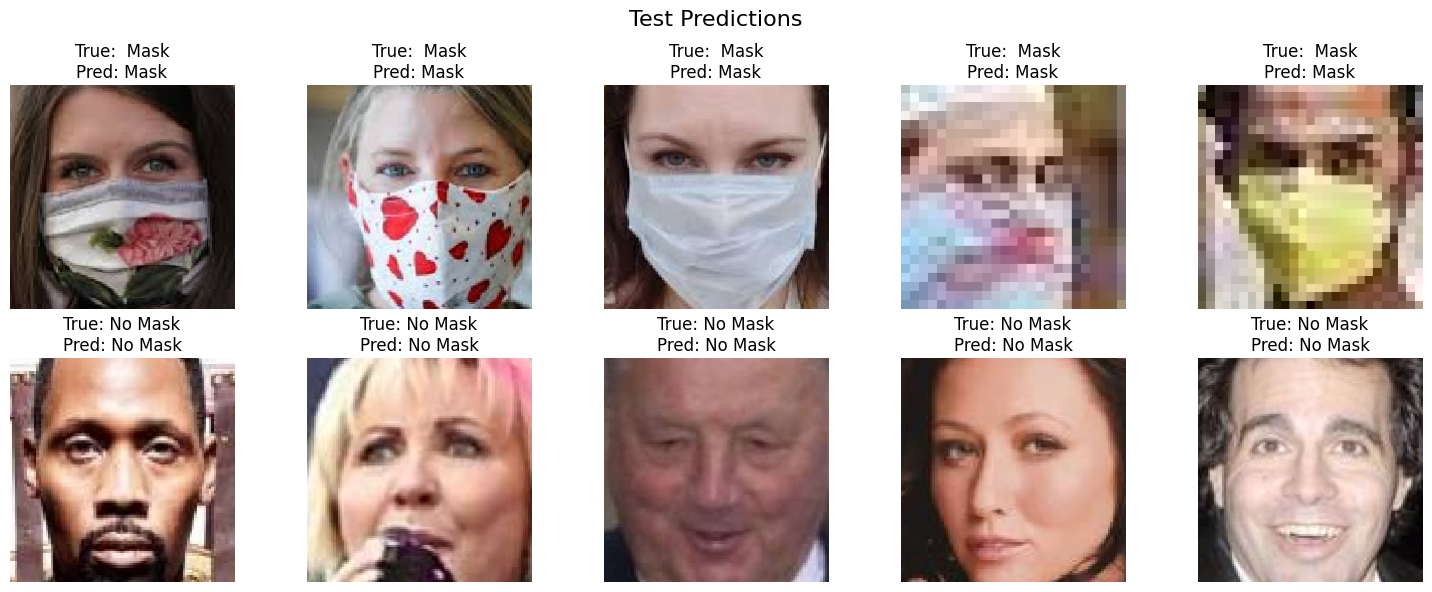

In [ ]:
def visualize_predictions(generator, model, title, samples_per_class=5):
    # Lists to store images for each class
    class_0_images = []  # No mask
    class_1_images = []  # With mask
    class_0_labels = []
    class_1_labels = []

    # Keep getting batches until we have enough samples of each class
    while len(class_0_images) < samples_per_class or len(class_1_images) < samples_per_class:
        images, labels = next(generator)
        predictions = model.predict(images)
        predictions = np.round(predictions).astype(int).flatten()

        # Sort images by their true labels
        for img, label in zip(images, labels):
            if label == 0 and len(class_0_images) < samples_per_class:  # No mask
                class_0_images.append(img)
                class_0_labels.append(label)
            elif label == 1 and len(class_1_images) < samples_per_class:  # With mask
                class_1_images.append(img)
                class_1_labels.append(label)

    # Combine the collected images and labels
    display_images = class_0_images + class_1_images
    display_labels = class_0_labels + class_1_labels

    # Make predictions on the collected images
    predictions = model.predict(np.array(display_images))
    predictions = np.round(predictions).astype(int).flatten()

    # Plot the results
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axes.flat):
        ax.imshow(display_images[i])
        ax.set_title(f"True: {' Mask' if display_labels[i]==0 else 'No Mask'}\n"
                    f"Pred: {'Mask' if predictions[i]==0 else 'No Mask'}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Visualize predictions on test images
visualize_predictions(test_generator, model, "Test Predictions")

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2

def test_single_image(model, image_path, img_height=224, img_width=224):
    """
    Enhanced test function for mask detection model with additional preprocessing
    and more detailed output
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)

    # Additional preprocessing steps
    # Convert to BGR (since MobileNetV2 was trained on BGR images)
    img_array_bgr = img_array[..., ::-1]

    # Normalize
    img_array = img_array_bgr / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array, verbose=0)  # Disable verbose output
    pred_class = np.round(prediction).astype(int)[0][0]
    confidence = prediction[0][0]

    # Prepare labels (0 = mask, 1 = no mask)
    label = "No Mask" if pred_class == 1 else "Mask"
    conf_percentage = confidence if pred_class == 1 else (1 - confidence)

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Original image
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    # Preprocessed image
    ax2.imshow(img_array_bgr[0] / 255.0)  # Display normalized BGR image
    ax2.set_title('Preprocessed Image\n(Model Input)')
    ax2.axis('off')

    # Add prediction info as figure suptitle
    plt.suptitle(f'Prediction: {label} (Confidence: {conf_percentage:.2%})\n' +
                f'Raw Model Output: {prediction[0][0]:.4f}',
                color='green' if conf_percentage > 0.9 else 'red',
                y=1.05)

    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nDetailed Analysis:")
    print("-" * 50)
    print(f"Prediction Class: {label}")
    print(f"Confidence: {conf_percentage:.2%}")
    print(f"Raw Model Output: {prediction[0][0]:.4f}")
    print("-" * 50)
    print("Interpretation Guide:")
    print("• Raw output close to 0 → Model thinks mask is present")
    print("• Raw output close to 1 → Model thinks no mask is present")
    if conf_percentage > 0.9:
        print("\nNote: High confidence prediction (>90%)")

    return pred_class, confidence

# Example usage:
# prediction, confidence = test_single_image(model, "path/to/image.jpg")

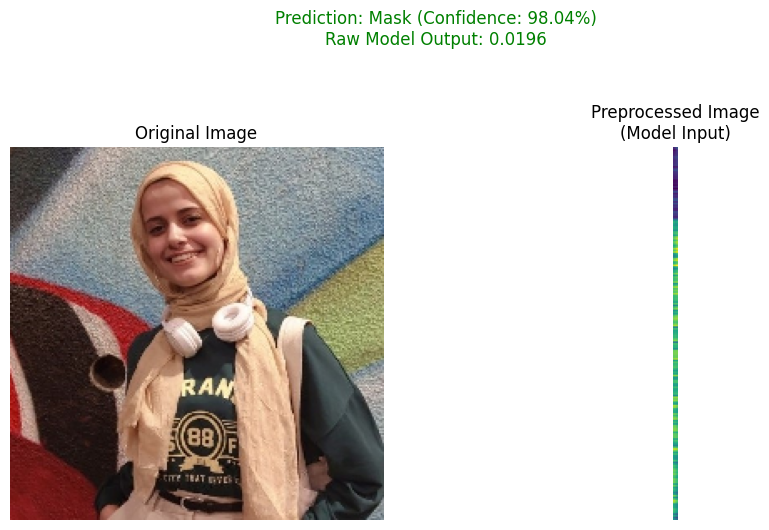


Detailed Analysis:
--------------------------------------------------
Prediction Class: Mask
Confidence: 98.04%
Raw Model Output: 0.0196
--------------------------------------------------
Interpretation Guide:
• Raw output close to 0 → Model thinks mask is present
• Raw output close to 1 → Model thinks no mask is present

Note: High confidence prediction (>90%)


In [ ]:
# Example usage
image_path = "/content/profile picture.jpg"
prediction, confidence = test_single_image(model, image_path)